# Project Name: Toxic Comment Classification Challenge
The main aim of this project is to identify and classify toxic online comments

Reference: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.model_selection import cross_validate
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df_train = pd.read_csv("/content/drive/My Drive/train.csv")
df_test_ = pd.read_csv("/content/drive/My Drive/test.csv")
df_test_labels = pd.read_csv("/content/drive/My Drive/test_labels.csv")

In [9]:
df_test_merged = pd.merge(df_test_, df_test_labels, on='id', how='inner')
df_test = df_test_merged[~(df_test_merged["toxic"] == -1)].reset_index()
df_test = df_test.drop(columns=["index"])

## Exploring Data

In [10]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [11]:
df_test_.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [12]:
df_test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [13]:
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [14]:
print(f"Train Records = {df_train.shape}")
print(f"Original Test samples = {df_test_.shape}")
print(f"Original test labels = {df_test_labels.shape}")
print(f"Test Records = {df_test.shape}")
#Note that df_test and df_test labels have same number of records

Train Records = (159571, 8)
Original Test samples = (153164, 2)
Original test labels = (153164, 7)
Test Records = (63978, 8)


In [15]:
df_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [17]:
df_train.isnull().sum()

,0
id,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


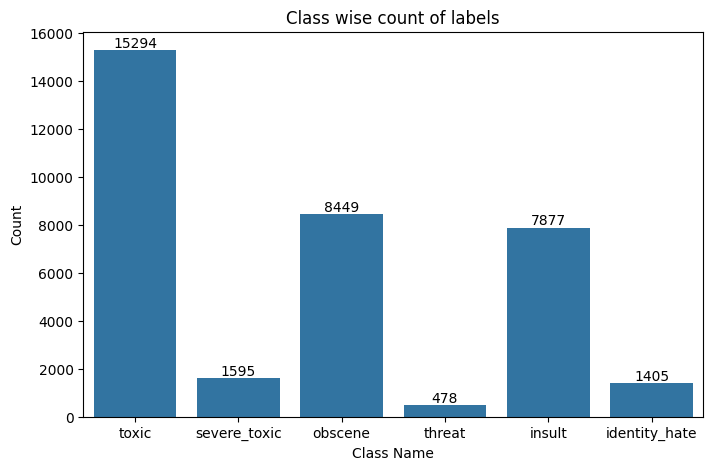

In [18]:
class_wise_count = df_train.iloc[:, 2:].sum()
plt.figure(figsize=(8, 5))
plt.title('Class wise count of labels')
barplot = sns.barplot(x=df_train.columns[2:], y=class_wise_count)

for i, value in enumerate(class_wise_count):
  barplot.text(i, value + 0.5, f'{value:.0f}', ha='center', va='bottom', fontsize=10)
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.show()

In [19]:
no_label_count = 0
records_noLabels = df_train.iloc[:, 2:].sum(axis = 1)
for i, count in records_noLabels.items():
  if count == 0:
    no_label_count += 1

print(f"Total records = {len(df_train)}")
print(f"Total records with no labels = {no_label_count}")

Total records = 159571
Total records with no labels = 143346


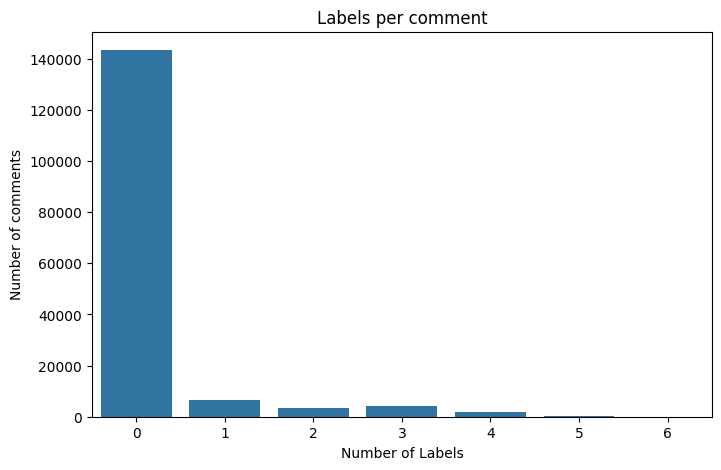

In [20]:
plt.figure(figsize=(8, 5))
plt.title('Labels per comment')
barplot = sns.countplot(x=records_noLabels.values)

plt.xlabel('Number of Labels')
plt.ylabel('Number of comments')
plt.show()

## Inferences from data Exploration:


*   There are **159571** train samples. The data consists of 8 columns id, comment_text and 6 target classes namely 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'
*   After removing the test samples whose ground truth is not provided, we now have **63978** test samples.
*   There are no NULL values in the training data.
*   89% of comments are positive which mean all target classes have values 0.
*   In the remaining negative data, most comments are Toxic followed by Obscene and Insult.
*   This confirms the fact that the dataset is quite unbalanced.









## Data Preprocessing

In [21]:
def remove_special_characters(text_):
  text = re.sub(r'http\S+', ' ', text_ ) # to remove links
  text = re.sub(r'[^\w\s]', ' ', text) # to remove punctuation, spaces, tabs and line breaks
  text = re.sub(r'\bhttps?://[a-zA-Z0-9-]+(?:\.[a-zA-Z0-9-]+)+\b', ' ', text) # to remove links
  text = re.sub(r'\s+', ' ', text).strip() # to remove extra spaces at the start, middle and end
  text = re.sub(r'\d', ' ', text)  # Removes numbers be it any number of digits
  text = re.sub(r'\n', ' ', text)
  text= re.sub(r'[\u4e00-\u9fff]+', ' ', text) # to remove chinese
  return text

def clean_comments(text):
    #tokenizing with words whose length >2
    tokenized_text = nltk.regexp_tokenize(text.lower(), r'(\b[\w]{2,}\b)')
    #lemmatizing each word
    lemmatizer = WordNetLemmatizer()
    cleaned_text = " ".join([lemmatizer.lemmatize(w) for w in tokenized_text])
    return cleaned_text.lower().strip()

def remove_stopwords(text):
  words = word_tokenize(text)
  stop_words = set(stopwords.words('english'))
  filtered_sentence = [word for word in words if word.lower() not in stop_words]
  return " ".join(filtered_sentence)

df_train['comment_text'] = df_train['comment_text'].apply(remove_special_characters)
df_test['comment_text'] = df_test['comment_text'].apply(remove_special_characters)

df_train['comment_text'] = df_train['comment_text'].apply(clean_comments)
df_test['comment_text'] = df_test['comment_text'].apply(clean_comments)

df_train['comment_text'] = df_train['comment_text'].apply(remove_stopwords)
df_test['comment_text'] = df_test['comment_text'].apply(remove_stopwords)

print(df_train['comment_text'].head(10))

0    explanation edits made username hardcore metal...
1    aww match background colour seemingly stuck th...
2    hey man really trying edit war guy constantly ...
3    make real suggestion improvement wondered sect...
4                        sir hero chance remember page
5               congratulation well use tool well talk
6                          cocksucker piss around work
7    vandalism matt shirvington article ha reverted...
8    sorry word nonsense wa offensive anyway intend...
9                 alignment subject contrary dulithgow
Name: comment_text, dtype: object


In [22]:
X_1 = df_train['comment_text']
y_1 = df_train.drop(columns=['id', 'comment_text'])
X_test_1 = df_test['comment_text']
y_test_1 = df_test.drop(columns=['id', 'comment_text'])

### To determine size of vocabulary and sequence length

In [23]:
# To determine max_words in vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_1)

# Computing total vocabulary size
vocab_size = len(tokenizer.word_index)
print(f"Total vocabulary size: {vocab_size}")

# Determining how many words cover 85% of the data
word_counts = tokenizer.word_counts
sorted_word_counts = sorted(word_counts.values(), reverse=True)
cumulative_sum = np.cumsum(sorted_word_counts)
coverage_85 = np.argmax(cumulative_sum >= 0.85 * cumulative_sum[-1]) + 1
print(f"Number of words covering 85% of data: {coverage_85}")

Total vocabulary size: 157101
Number of words covering 85% of data: 5077


In [24]:
max_words = coverage_85  # Maximum number of words in vocabulary
max_len = int(np.percentile([len(seq) for seq in X_1], 95))

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_1)

#padding to equal legths on training samples
X = tokenizer.texts_to_sequences(X_1)
X = pad_sequences(X, maxlen=max_len, padding='post')
y = np.array(y_1)

#padding to equal legths on test samples
X_test = tokenizer.texts_to_sequences(X_test_1)
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')
y_test = np.array(y_test_1)

# Split into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Models

## Binary Relevance approach using oneVrest classifier



1.   With Naive Bayes as base classifier





In [25]:
MNB_pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb_model', OneVsRestClassifier(MultinomialNB(), n_jobs=-1))
])

In [26]:
MNB_pipeline_bin = Pipeline([
    ('tfidf', CountVectorizer(binary = True)),
    ('nb_model', OneVsRestClassifier(MultinomialNB(), n_jobs=-1))
])

2.   With Logistic Regression as base classifier



In [27]:
LR_pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('lr_model', OneVsRestClassifier(LogisticRegression(class_weight="balanced"), n_jobs=-1))
])

In [28]:
LR_pipeline_bin = Pipeline([
    ('tfidf', CountVectorizer(binary = True)),
    ('lr_model', OneVsRestClassifier(LogisticRegression(class_weight="balanced"), n_jobs=-1))
])

## RNN based model

In [ ]:
# Number of classes
num_classes = y_train.shape[1]

# Compute class weights for each class
class_weights = {}
for i in range(num_classes):
    weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train[:, i])
    class_weights[i] = weights[1]

# Combine class weights into a single sample weight
def compute_sample_weight(y_train):
    # Initialize sample weights as zeros
    sample_weights = np.zeros(y_train.shape[0], dtype=float)

    # Iterate through each sample
    for i in range(y_train.shape[0]):
        positive_weights = [class_weights[j] for j in range(num_classes) if y_train[i, j] == 1]
        sample_weights[i] = sum(positive_weights) if positive_weights else 1.0

    return sample_weights

sample_weights = compute_sample_weight(y_train)

# Build the RNN model
RNN_model = Sequential([
    # Embedding layer: maps words to dense vectors
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len, mask_zero=True),
    # RNN layer
    SimpleRNN(64, return_sequences=False),
    # Dropout for regularization
    Dropout(0.3),
    # Output layer: One neuron per class with sigmoid activation
    Dense(y.shape[1], activation='sigmoid')  # Number of output classes
])

# Compile the model
RNN_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_RNN = RNN_model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=5,
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 1785s 446ms/step - accuracy: 0.5817 - loss: 1.9565 - val_accuracy: 0.8033 - val_loss: 0.1815
Epoch 2/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 1798s 451ms/step - accuracy: 0.6425 - loss: 1.3141 - val_accuracy: 0.8881 - val_loss: 0.1404
Epoch 3/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 1823s 451ms/step - accuracy: 0.6527 - loss: 1.1100 - val_accuracy: 0.9298 - val_loss: 0.1218
Epoch 4/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 1824s 451ms/step - accuracy: 0.6739 - loss: 1.0249 - val_accuracy: 0.8347 - val_loss: 0.1171
Epoch 5/5
 272/3990 ━━━━━━━━━━━━━━━━━━━━ 26:45 432ms/step - accuracy: 0.7103 - loss: 0.8786

In [ ]:
RNN_model.summary()

# Model Comparison - Metrics

In [ ]:
def model_metrics(pipeline, X_train, X_test, y_train, y_test):
    # train model
    pipeline.fit(X_train, y_train)
    # predict from model
    y_pred = pipeline.predict(X_test)
    pred_probs = pipeline.predict_proba(X_test)
    # print metrics
    roc_auc = roc_auc_score(y_test, pred_probs)
    accuracy = accuracy_score(y_test, y_pred)
    print('roc_auc:', roc_auc)
    print('accuracy:', accuracy)
    print('classification report')
    report = classification_report(y_test, y_pred, target_names=y_train.columns, output_dict=True)
    print(classification_report(y_test, y_pred, target_names=y_train.columns))
    return pipeline, roc_auc, accuracy, report

In [ ]:
MNB_tfidf, roc_auc_MNB_tfidf, accuarcy_MNB_tfidf, report_MNB_tfidf = model_metrics(MNB_pipeline_tfidf, X_1, X_test_1, y_1, y_test_1)

In [ ]:
MNB_bin, roc_auc_MNB_bin, accuarcy_MNB_bin, report_MNB_bin = model_metrics(MNB_pipeline_bin, X_1, X_test_1, y_1, y_test_1)

In [ ]:
LR_tfidf, roc_auc_LR_tfidf, accuarcy_LR_tfidf, report_LR_tfidf = model_metrics(LR_pipeline_tfidf, X_1, X_test_1, y_1, y_test_1)

In [ ]:
LR_bin, roc_auc_LR_bin, accuarcy_LR_bin, report_LR_bin = model_metrics(LR_pipeline_bin, X_1, X_test_1, y_1, y_test_1)

In [ ]:
# Evaluate the model
y_pred_prob_RNN = RNN_model.predict(X_test)  # Predict probabilities
y_pred_RNN = (y_pred_prob_RNN > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate classification report
print('roc_auc:', roc_auc_score(y_test, y_pred_prob_RNN))
print('accuracy:', accuracy_score(y_test, y_pred_RNN))
print(classification_report(y_test, y_pred_RNN, target_names=y_1.columns))
roc_auc_rnn = roc_auc_score(y_test, y_pred_prob_RNN)
accuarcy_rnn = accuracy_score(y_test, y_pred_RNN)
report_RNN = classification_report(y_test, y_pred_RNN, target_names=y_1.columns, output_dict=True)

In [ ]:
train_loss = history_RNN.history['loss']
val_loss = history_RNN.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for RNN model')
plt.legend()
plt.grid(True)
plt.show()
print("From the below plot, we can conclude model is not overfitting and actually working good. A model whose loss curves decrease and remain close to each other mean that it's learning is in a balanced way and generalizing well to the data, without significant overfitting")

In [ ]:
labels = y_1.columns.values
def plot_roc_curve(test_labels, predict_prob):
    fpr, tpr, thresholds = roc_curve(test_labels, predict_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend(labels)

def plot_pipeline_roc_curve(pipeline, X_train, X_test, y_train, y_test):
    for label in labels:
        pipeline.fit(X_train, y_train[label])
        pred_probs = pipeline.predict_proba(X_test)[:, 1]
        plot_roc_curve(y_test[label], pred_probs)

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title('ROC curve for LR_tfidf')
plot_pipeline_roc_curve(LR_pipeline_tfidf, X_1, X_test_1, y_1, y_test_1)
plt.subplot(2, 2, 2)
plt.title('ROC curve for LR_bin')
plot_pipeline_roc_curve(LR_pipeline_bin, X_1, X_test_1, y_1, y_test_1)
plt.subplot(2, 2, 3)
plt.title('ROC curve for MNB_tfidf')
plot_pipeline_roc_curve(MNB_pipeline_tfidf, X_1, X_test_1, y_1, y_test_1)
plt.subplot(2, 2, 4)
plt.title('ROC curve for MNB_bin')
plot_pipeline_roc_curve(MNB_pipeline_bin, X_1, X_test_1, y_1, y_test_1)
# plt.title('ROC curve for RNN')
# plot_pipeline_roc_curve(RNN_model, X_train, X_test, y_train, y_test)
# Adjust layout for better spacing
plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['MNB_tfidf', 'MNB_bin', 'LR_tfidf', 'LR_bin', 'RNN_model']
roc_auc_scores = [roc_auc_MNB_tfidf, roc_auc_MNB_bin, roc_auc_LR_tfidf, roc_auc_LR_bin, roc_auc_rnn]

# Create a barplot
plt.figure(figsize=(6,4))
sns.barplot(x=models, y=roc_auc_scores, palette='viridis', hue = models)

# Add title and labels
plt.title('ROC AUC Scores for Different Models', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('ROC AUC Score', fontsize=14)

# Annotate the bars with scores
for i, score in enumerate(roc_auc_scores):
    plt.text(i, score + 0.005, f'{score:.2f}', ha='center', fontsize=12)

plt.ylim(0.8, 1.0)
plt.tight_layout()
plt.show()


In [ ]:
report_df_MNB_tfidf = pd.DataFrame(report_MNB_tfidf).transpose().drop(columns = ["support"])[:6]
report_df_MNB_bin = pd.DataFrame(report_MNB_bin).transpose().drop(columns = ["support"])[:6]
report_df_LR_tfidf = pd.DataFrame(report_LR_tfidf).transpose().drop(columns = ["support"])[:6]
report_df_LR_bin = pd.DataFrame(report_LR_bin).transpose().drop(columns = ["support"])[:6]
report_df_RNN = pd.DataFrame(report_RNN).transpose().drop(columns = ["support"])[:6]

# Create a figure and axes explicitly
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plotting each DataFrame on its respective subplot
report_df_MNB_tfidf.plot(kind='bar', width=0.8, ax=axes[0])
axes[0].set_title('Precision, Recall, F1-score in MNB_tfidf')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Scores')
axes[0].legend(title='Metrics', loc='upper left')

report_df_MNB_bin.plot(kind='bar', width=0.8, ax=axes[1])
axes[1].set_title('Precision, Recall, F1-score in MNB_bin')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Scores')
axes[1].legend(title='Metrics', loc='upper left')

report_df_LR_tfidf.plot(kind='bar', width=0.8, ax=axes[2])
axes[2].set_title('Precision, Recall, F1-score in LR_tfidf')
axes[2].set_xlabel('Classes')
axes[2].set_ylabel('Scores')
axes[2].legend(title='Metrics', loc='upper left')

report_df_LR_bin.plot(kind='bar', width=0.8, ax=axes[3])
axes[3].set_title('Precision, Recall, F1-score in LR_bin')
axes[3].set_xlabel('Classes')
axes[3].set_ylabel('Scores')
axes[3].legend(title='Metrics', loc='upper left')

report_df_RNN.plot(kind='bar', width=0.8, ax=axes[4])
axes[4].set_title('Precision, Recall, F1-score in RNN model')
axes[4].set_xlabel('Classes')
axes[4].set_ylabel('Scores')
axes[4].legend(title='Metrics', loc='upper left')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


#Test Prediction

In [ ]:
labels = y_train.columns.values
sentence = 'hello dick wikipedia fuckwhit ban'
sentence = remove_special_characters(sentence)
sentence = clean_comments(sentence)
sentence = remove_stopwords(sentence)
results = LR_pipeline_tfidf.predict([sentence])[0]
for label, result in zip(labels, results):
    print("%14s %5s" % (label, result))
